In [21]:
import os
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn import preprocessing as pp
import shap
import matplotlib.pyplot as plt

## Coef analysis on data from tuning
### Enet

In [2]:
X = pd.read_csv('../Predictor_IgGMall_PosNeg_interact.txt', sep='\t', index_col=0)
Y = pd.read_csv('../Response.txt', sep='\t', index_col=0).squeeze()
Y.replace('Melioid', 1, inplace=True)
Y.replace('Negative', 0, inplace=True)


if not os.path.isdir("Tables"):
    os.makedirs("Tables")
os.chdir("Tables")

enet= LogisticRegression(penalty = 'elasticnet', C=100, l1_ratio=0.9, solver = 'saga', max_iter=int(1e6)).fit(X,Y)

EnetCOEFS = pd.DataFrame(np.transpose(enet.coef_), X.columns, columns=['Coeffs']).sort_values('Coeffs', ascending=False).assign(Model='Enet')

### Logit

In [3]:
LassoSTRONG= LogisticRegression(penalty = 'l1', C=0.0000599484,solver = 'saga', max_iter=int(1e6)).fit(X,Y)

LassoSTRONG_coefs = pd.DataFrame(np.transpose(LassoSTRONG.coef_), X.columns, columns=['Coeffs']).sort_values('Coeffs', ascending=False).assign(Model='LassoSTRONG')

LassoWEAK= LogisticRegression(penalty = 'l1', C=100,solver = 'saga', max_iter=int(1e6)).fit(X,Y)

LassoWEAK_coefs = pd.DataFrame(np.transpose(LassoWEAK.coef_), X.columns, columns=['Coeffs']).sort_values('Coeffs', ascending=False).assign(Model='LassoWEAK')

RidgeSTRONG= LogisticRegression(penalty = 'l2', C=0.0000599484,solver = 'saga', max_iter=int(1e6)).fit(X,Y)

RidgeSTRONG_coefs = pd.DataFrame(np.transpose(RidgeSTRONG.coef_), X.columns, columns=['Coeffs']).sort_values('Coeffs', ascending=False).assign(Model='RidgeSTRONG')

RidgeWEAK= LogisticRegression(penalty = 'l2', C=100,solver = 'saga', max_iter=int(1e6)).fit(X,Y)

RidgeWEAK_coefs = pd.DataFrame(np.transpose(RidgeWEAK.coef_), X.columns, columns=['Coeffs']).sort_values('Coeffs', ascending=False).assign(Model='RidgeWEAK')



### XGB

In [4]:
RAND=np.random.RandomState(4)

XGB_underfit = xgb =  XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=RAND, colsample_bytree=0.05, learning_rate=0.021544346900318832, max_depth=11, n_estimators=10, subsample=0.1).fit(X,Y) #, scale_pos_weight=len(Y1==0)/len(Y1==1) BinaryFocalLoss

XGB_overfit = xgb =  XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=RAND, colsample_bytree=0.05, learning_rate=0.001, max_depth=3, n_estimators=25, subsample=0.4).fit(X, Y)

XGB_underfit_feats = pd.DataFrame({'Coeffs':XGB_underfit.feature_importances_, 'Antigen':X.columns.to_list()}).sort_values('Coeffs', ascending=False)

XGB_overfit_feats = pd.DataFrame({'Coeffs':XGB_overfit.feature_importances_, 'Antigen':X.columns.to_list()}).sort_values('Coeffs', ascending=False)

In [5]:
with pd.ExcelWriter("Interaction_Coeffs.xlsx") as writer:
    EnetCOEFS.to_excel(writer, sheet_name="Week1_Enet", index=True)
    LassoSTRONG_coefs.to_excel(writer, sheet_name="Week1_LassoStrong", index=True)
    LassoWEAK_coefs.to_excel(writer, sheet_name="Week1_LassoWeak", index=True)
    RidgeSTRONG_coefs.to_excel(writer, sheet_name="Week1_RidgeStrong", index=True)
    RidgeWEAK_coefs.to_excel(writer, sheet_name="Week1_RidgeWeak", index=True)
    XGB_underfit_feats.to_excel(writer, sheet_name="XGB_underfit", index=True)
    XGB_overfit_feats.to_excel(writer, sheet_name="XGB_overfit", index=True)

## Week 1 Score and coefs from Validation set

In [16]:
## copy validation set from IgG and IgM and concatenate.
igg = pd.read_csv('../../../IgG/ValidationSet/ValidationSet.txt', sep='\t', index_col=0)
igm = pd.read_csv('../../../IgM/ValidationSet/ValidationSet.txt', sep='\t', index_col=0)


iggm = pd.concat([igg, igm])
iggm= iggm.loc[iggm['TimeGroup']!='Prior']


iggm.TimeGroup.replace('Healthy',0, inplace=True)
iggm.TimeGroup.replace('Week1',1, inplace=True)
iggm.TimeGroup.replace('Week2',2, inplace=True)
iggm.TimeGroup.replace('Week3',3, inplace=True)
iggm.TimeGroup.replace('Week4+',4, inplace=True)

iggm.TimeGroup = iggm.TimeGroup.astype(int)

X2 = iggm.drop(['index','PatientID', 'SerumID', 'Status', 'Rep'], axis=1).copy().reset_index(drop=True)
X2 = pd.get_dummies(X2)
Ytrue = iggm.Status.copy().replace('Melioid', 1).replace('Negative', 0)

poly = pp.PolynomialFeatures(interaction_only=True,include_bias = False)
Xarr = poly.fit_transform(X2)
Xint = pd.DataFrame(Xarr, columns=poly.get_feature_names_out(X2.columns))


In [14]:
iggm.dtypes

index                int64
PatientID           object
SerumID             object
TimeGroup            int64
Status              object
Type                object
Rep                  int64
BPSL1201_IMPS      float64
BPSL1404_ClpX      float64
BPSL1743_Arg       float64
BPSL2096_AhpC      float64
BPSL2522_OmpA      float64
BPSL2697_GroEL     float64
BPSL2827_DNAK      float64
BPSL3222_rpIL      float64
BPSL3396_AtpD      float64
BPSS0135           float64
BPSS0476_GroS      float64
BPSS0477_GroEL2    float64
BPSS0530           float64
BPSS1498_HCP1.B    float64
BPSS1652           float64
BPSS1769_NADH      float64
BPSS1850           float64
CPS                float64
LPSA               float64
LPSB               float64
dtype: object

In [18]:
print("ENET: roc_auc score", roc_auc_score(Ytrue, enet.predict_proba(Xint)[:, 1]))
print('LassoSTRONG: roc_auc score', roc_auc_score(Ytrue, LassoSTRONG.predict_proba(Xint)[:, 1]))
print("LassoWEAK: roc_auc score", roc_auc_score(Ytrue, LassoWEAK.predict_proba(Xint)[:, 1]))
print("RidgeSTRONG: roc_auc score", roc_auc_score(Ytrue, RidgeSTRONG.predict_proba(Xint)[:, 1]))
print("RidgeWEAK: roc_auc score", roc_auc_score(Ytrue, RidgeWEAK.predict_proba(Xint)[:, 1]))
print("XGB_underfit: roc_auc score", roc_auc_score(Ytrue, XGB_underfit.predict_proba(Xint)[:, 1]))
print("XGB_overfit: roc_auc score", roc_auc_score(Ytrue, XGB_overfit.predict_proba(Xint)[:, 1]))

# roc_auc_score(Yunder, enet.predict_proba(Xunder)[:, 1])

ENET: roc_auc score 0.9427579365079365
LassoSTRONG: roc_auc score 0.9428075396825396
LassoWEAK: roc_auc score 0.9427579365079365
RidgeSTRONG: roc_auc score 0.9427579365079365
RidgeWEAK: roc_auc score 0.9427579365079365
XGB_underfit: roc_auc score 1.0
XGB_overfit: roc_auc score 1.0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


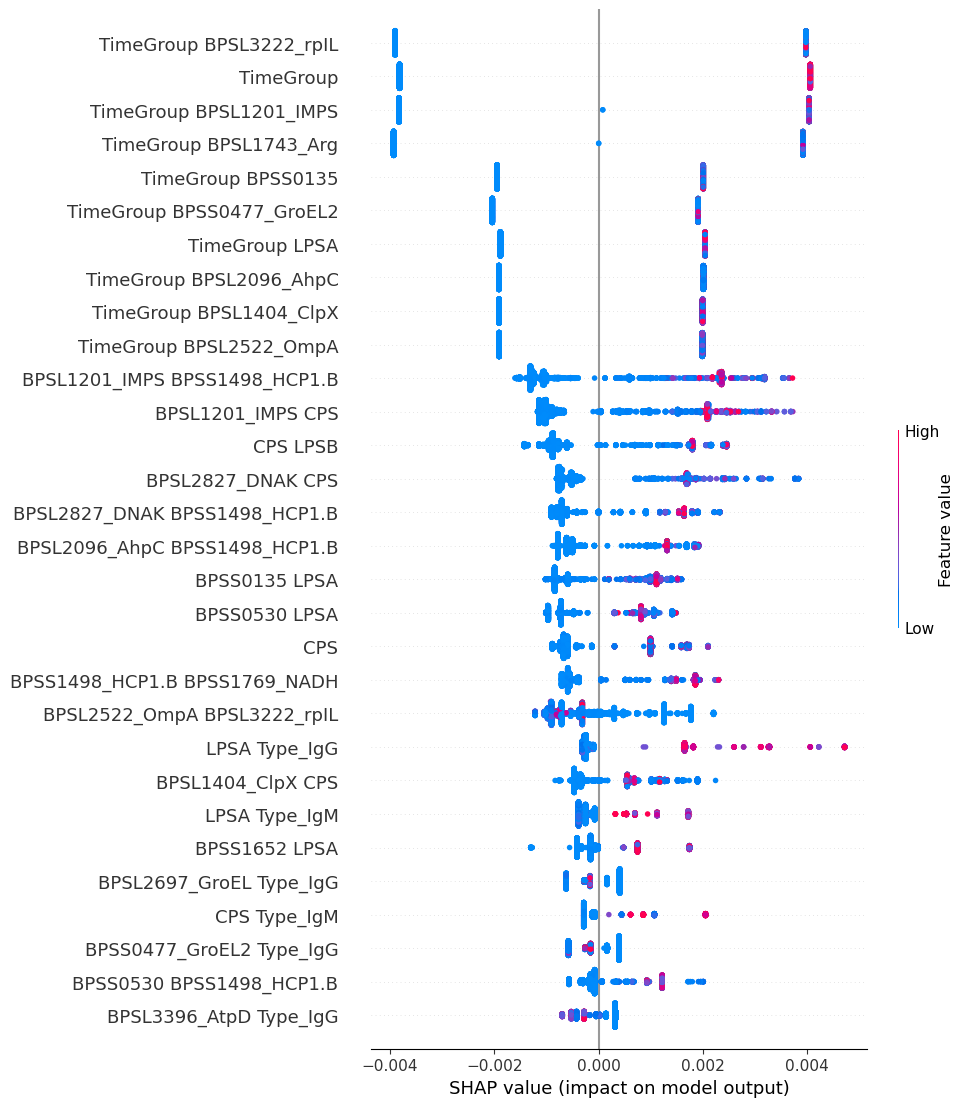

In [22]:
# XGB_overfit.fit(X,Y) # Should probably refit repeatedly with a random seed like above for permutation importance.
shap_values = shap.TreeExplainer(XGB_overfit).shap_values(X)
shap.summary_plot(shap_values, X, show=False, max_display=30)
plt.savefig('SHAP_SummaryPlot.png', dpi=300, bbox_inches="tight", transparent=False)